In [29]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import preprocessing


from xgboost import XGBClassifier

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from numpy import mean,std
import matplotlib.pyplot as plt


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [30]:
print(os.getcwd())

c:\Users\Joseph\Desktop\ML\Flu-Shot-Learning\XGBoost\tuned_XGBoost


In [31]:
train_features = pd.read_csv('C:/Users/Joseph/Desktop/ML/Flu-Shot-Learning/datasets/training_set_features.csv')
train_labels = pd.read_csv('C:/Users/Joseph/Desktop/ML/Flu-Shot-Learning/datasets/training_set_labels.csv')
train_data = pd.merge(train_features, train_labels, on = 'respondent_id', how='inner')

test_features = pd.read_csv('C:/Users/Joseph/Desktop/ML/Flu-Shot-Learning/datasets/test_set_features.csv')

In [32]:
all_dataset = pd.concat([train_data, test_features])

In [33]:
train_data.shape

(26707, 38)

In [34]:
train_data.head(2)

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1


# Encoding

In [35]:
label_encoder = preprocessing.LabelEncoder()

In [36]:
for col in ['age_group', 'education', 'race', 'sex', 
            'income_poverty', 'marital_status', 'rent_or_own', 
            'employment_status', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation']:
    all_dataset[col] = label_encoder.fit_transform(all_dataset[col].astype(str))

In [37]:
all_dataset.shape

(53415, 38)

# Handling Null Values

In [38]:
# Impute with mean & median
train_data_impute_mean = all_dataset.copy()

In [39]:
train_data_impute_mean.fillna(train_data_impute_mean.mean(), inplace=True)

In [40]:
dataset = train_data_impute_mean.copy()

In [41]:
submission_train_dataset = dataset.loc[dataset['respondent_id'] >= len(train_data)] 
submission_train_dataset = submission_train_dataset.drop(['h1n1_vaccine','seasonal_vaccine'], axis=1)
# submission_train_dataset.head()

In [42]:
dataset = dataset.loc[dataset['respondent_id'] < len(train_data)]

In [43]:
train_data['h1n1_vaccine'].value_counts()

0    21033
1     5674
Name: h1n1_vaccine, dtype: int64

# Split Train 

In [44]:
y1 = dataset['h1n1_vaccine'].astype(int)
y2 = dataset['seasonal_vaccine'].astype(int)

X = dataset.drop(['h1n1_vaccine', 'seasonal_vaccine'], axis=1)


In [45]:
# X = X.drop(['respondent_id'], axis = 1)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y1, test_size=0.15, random_state=1)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, test_size=0.15, random_state=1)

# Modeling

# h1n1_vaccine

In [46]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# define search space
space= {   
            'eta' : hp.quniform('eta', 0, 1, 0.05),
            'gamma' : hp.quniform('gamma', 0, 999, 10),
            'max_depth' : hp.quniform('max_depth', 0, 100, 10),
            'min_child_weight' : hp.quniform('min_child_weight', 0, 999, 10),
            'alpha' : hp.quniform('alpha', 0, 999, 10),
            'reg_lambda' : hp.quniform('reg_lambda', 0, 999, 10),
            'subsample' : hp.quniform('subsample', 0, 1, 10)
        }


# Regression: 
def hyperparameter_tuning(space):
    model1=XGBClassifier( 
                            verbosity = 0,
                            objective = 'binary:logistic',
                            use_label_encoder=False,
                            eta = round(space['eta'], 1),
                            gamma = space['gamma'],
                            max_depth = int(space['max_depth']),
                            min_child_weight = space['min_child_weight'],
                            alpha = space['alpha'],
                            reg_lambda = space['reg_lambda'],
                            subsample = space['subsample']
                        )
    
    evaluation = [( X_train1, y_train1), (X_test1, y_test1)]
    
    model1 = model1.fit(X_train1, y_train1)

    # score = model1.score(X_train1, y_train1)
    # print("Training Score: {score}".format(score=score))

    # y_pred1 = model1.predict(X_test1)


    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    roc_auc_scores = cross_val_score(model1, X_train1, y_train1, scoring='roc_auc', cv=cv, n_jobs=-1)
    mean_roc_auc = mean(roc_auc_scores)

    # roc_auc = roc_auc_score(y_test1, y_pred1)
    # print("ROC AUC : {roc_auc}".format(roc_auc=roc_auc))

    print("Mean ROC AUC: {roc_auc:.2f} -- Model: {model}".format(roc_auc = mean_roc_auc, model=model1))
    # change the metric if you like
    return {'loss': -mean_roc_auc, 'status': STATUS_OK, 'model': model1}



trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)

print (best)

Mean ROC AUC: 0.50 -- Model: XGBClassifier(alpha=30.0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.4, gamma=950.0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.400000006,
              max_delta_step=0, max_depth=40, min_child_weight=940.0,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=16, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=30, reg_lambda=260.0, scale_pos_weight=1, subsample=0.0,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)
Mean ROC AUC: 0.50 -- Model: XGBClassifier(alpha=400.0, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              enable_categorical=False, eta=1.0, gamma=570.0, gpu_id=-1,
              importance_type

In [47]:
# define model

xgb_model1 = XGBClassifier(hyperparameters = best,  use_label_encoder=False)
xgb_model1.fit(X_train1, y_train1)

score = xgb_model1.score(X_train1, y_train1)
print("Training Score: {score:.2f}".format(score = mean(score)))
print("="*100)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
roc_auc_scores = cross_val_score(xgb_model1, X_train1, y_train1, scoring='roc_auc', cv=cv, n_jobs=-1)
print("Mean ROC AUC: {score:.5f}".format(score = mean(roc_auc_scores)))
print("="*100)

y_pred1 = xgb_model1.predict(X_test1)
cm = confusion_matrix(y_test1, y_pred1)
print("Confusion Matrix\n {cm}".format(cm=cm))
print("="*100)

cr = classification_report(y_test1, y_pred1)
print("Classification Report \n", cr)

Training Score: 0.94
Mean ROC AUC: 0.85121
Confusion Matrix
 [[2981  190]
 [ 385  451]]
Classification Report 
               precision    recall  f1-score   support

           0       0.89      0.94      0.91      3171
           1       0.70      0.54      0.61       836

    accuracy                           0.86      4007
   macro avg       0.79      0.74      0.76      4007
weighted avg       0.85      0.86      0.85      4007



In [48]:
train_scores, test_scores = list(), list()

last_column = len(X_train1.columns)+1

values = [i for i in range(1,last_column)]

# evaluate a decision tree for each depth
for i in values:
	# configure the model
	model = xgb_model1
	# fit model on the training dataset
	model.fit(X_train1, y_train1)
	# evaluate on the train dataset
	train_yhat = model.predict(X_train1)
	train_acc = accuracy_score(y_train1, train_yhat)
	train_scores.append(train_acc)
	# evaluate on the test dataset
	test_yhat = model.predict(X_test1)
	test_acc = accuracy_score(y_test1, test_yhat)
	test_scores.append(test_acc)
	# summarize progress
	# print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

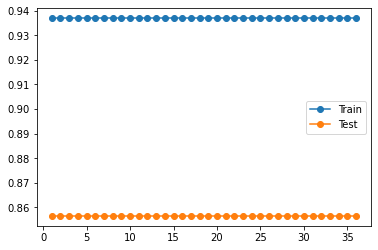

In [49]:
# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')

plt.legend()
plt.show()

# seasonal_vaccine

In [50]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# define search space
space= {   
            'eta' : hp.quniform('eta', 0, 1, 0.05),
            'gamma' : hp.quniform('gamma', 0, 999, 10),
            'max_depth' : hp.quniform('max_depth', 0, 100, 10),
            'min_child_weight' : hp.quniform('min_child_weight', 0, 999, 10),
            'alpha' : hp.quniform('alpha', 0, 999, 10),
            'reg_lambda' : hp.quniform('reg_lambda', 0, 999, 10),
            'subsample' : hp.quniform('subsample', 0, 1, 10)
        }

# Regression: 
def hyperparameter_tuning(space):
    model2=XGBClassifier( 
                            verbosity = 0,
                            objective = 'binary:logistic',
                            use_label_encoder=False,
                            eta = round(space['eta'], 1),
                            gamma = space['gamma'],
                            max_depth = int(space['max_depth']),
                            min_child_weight = space['min_child_weight'],
                            alpha = space['alpha'],
                            reg_lambda = space['reg_lambda'],
                            subsample = space['subsample']
                        )
    
    evaluation = [( X_train2, y_train2), (X_test2, y_test2)]
    
    model2 = model2.fit(X_train2, y_train2)

    # score = model2.score(X_train2, y_train2)
    # print("Training Score: {score}".format(score=score))

    # y_pred2 = model2.predict(X_test2)


    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    roc_auc_scores = cross_val_score(model2, X_train2, y_train2, scoring='roc_auc', cv=cv, n_jobs=-1)
    mean_roc_auc = mean(roc_auc_scores)

    # roc_auc = roc_auc_score(y_test2, y_pred2)
    # print("ROC AUC : {roc_auc}".format(roc_auc=roc_auc))

    print("Mean ROC AUC: {roc_auc:.2f} -- Model: {model}".format(roc_auc = mean_roc_auc, model=model2))
    # change the metric if you like
    return {'loss': -mean_roc_auc, 'status': STATUS_OK, 'model': model2}



trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)

print (best)

Mean ROC AUC: 0.50 -- Model: XGBClassifier(alpha=280.0, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              enable_categorical=False, eta=0.7, gamma=150.0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.699999988, max_delta_step=0, max_depth=80,
              min_child_weight=10.0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=280, reg_lambda=790.0,
              scale_pos_weight=1, subsample=0.0, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, ...)
Mean ROC AUC: 0.50 -- Model: XGBClassifier(alpha=650.0, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              enable_categorical=False, eta=0.6, gamma=510.0, gpu_id=-1,
              importance_typ

In [51]:
# define model
xgb_model2 = XGBClassifier(hyperparameters = best, use_label_encoder=False)
xgb_model2.fit(X_train2, y_train2)

score = xgb_model2.score(X_train2, y_train2)
print("Training Score: {score:.2f}".format(score = mean(score)))
print("="*100)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
roc_auc_scores = cross_val_score(xgb_model2, X_train2, y_train2, scoring='roc_auc', cv=cv, n_jobs=-1)
print("Mean ROC AUC: {score:.5f}".format(score = mean(roc_auc_scores)))
print("="*100)

y_pred2 = xgb_model2.predict(X_test2)
cm = confusion_matrix(y_test2, y_pred2)
print("Confusion Matrix\n {cm}".format(cm=cm))
print("="*100)

cr = classification_report(y_test2, y_pred2)
print("Classification Report \n", cr)

Training Score: 0.89
Mean ROC AUC: 0.84921
Confusion Matrix
 [[1710  449]
 [ 463 1385]]
Classification Report 
               precision    recall  f1-score   support

           0       0.79      0.79      0.79      2159
           1       0.76      0.75      0.75      1848

    accuracy                           0.77      4007
   macro avg       0.77      0.77      0.77      4007
weighted avg       0.77      0.77      0.77      4007



In [52]:
train_scores, test_scores = list(), list()

last_column = len(X_train2.columns)+1

values = [i for i in range(1,last_column)]

# evaluate a decision tree for each depth
for i in values:
	# configure the model
	model = xgb_model2
	# fit model on the training dataset
	model.fit(X_train2, y_train2)
	# evaluate on the train dataset
	train_yhat = model.predict(X_train2)
	train_acc = accuracy_score(y_train2, train_yhat)
	train_scores.append(train_acc)
	# evaluate on the test dataset
	test_yhat = model.predict(X_test2)
	test_acc = accuracy_score(y_test2, test_yhat)
	test_scores.append(test_acc)
	# summarize progress
	# print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

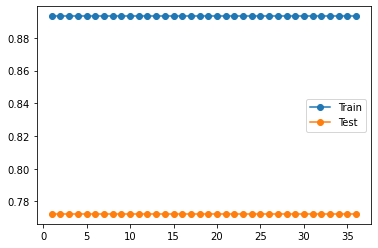

In [53]:
# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')

plt.legend()
plt.show()

## Predictions

In [54]:
# test_features = test_features.fillna(0, inplace=True)
# test_features.head(1)

In [55]:
h1n1_vaccine_submission = xgb_model1.predict(submission_train_dataset).astype(int)

seasonal_vaccine_submission = xgb_model2.predict(submission_train_dataset).astype(int)

In [56]:
submission_train_dataset.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,5.0,1.0,1.0,5.0,1.0,1.0,1,2,1,0,1,1,1,0,7,0,1.0,0.0,1,7
1,26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,4.0,1.0,1.0,4.0,1.0,1.0,0,0,3,1,2,1,1,0,1,2,3.0,0.0,1,21
2,26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.883824,5.0,4.0,2.0,5.0,4.0,4.0,3,2,3,1,1,0,0,0,5,2,1.0,0.0,11,13
3,26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.000000,4.0,2.0,2.0,4.0,4.0,2.0,4,0,3,0,0,0,0,1,5,0,1.0,0.0,10,11
4,26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.000000,5.0,2.0,4.0,4.0,4.0,2.0,1,0,0,0,0,1,0,0,6,2,0.0,1.0,4,10


In [57]:
submission = pd.DataFrame({
                            "respondent_id": test_features.respondent_id,
                            "h1n1_vaccine": h1n1_vaccine_submission.astype('float64'),
                            "seasonal_vaccine": seasonal_vaccine_submission.astype('float64')
    })

In [58]:
submission.head(5)

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.0,0.0
1,26708,0.0,0.0
2,26709,0.0,1.0
3,26710,0.0,1.0
4,26711,0.0,1.0


In [59]:
submission.to_csv('tuned_XGBoost_submission.csv', index=False)